In [17]:
using Pkg; Pkg.activate("../tambo/")
Pkg.add("Roots")
using Plots

using Random, LinearAlgebra, Roots

using Revise
push!(LOAD_PATH, String(@__DIR__)*"/../tambo/src")
using Tambo
using StaticArrays
using PyCall; np=pyimport("numpy")

  Activating project at `~/research/TAMBO-MC/tambo`
   Resolving package versions...
  No Changes to `~/research/TAMBO-MC/Tambo/Project.toml`
  No Changes to `~/research/TAMBO-MC/Tambo/Manifest.toml`


PyObject <module 'numpy' from '/Users/jlazar/anaconda3/envs/qcml/lib/python3.8/site-packages/numpy/__init__.py'>

# Make a ~~fake~~ real valley

In [18]:
# function f(x, center, width, intercept = -125)
#     x = x-center
#     a = (3000-intercept)/(width/2)^2
#     a*x^2+intercept
# end

# function my_valley(x, y)
#     ledge = 1000+200*sin(y/200)
#     redge = 2500+300*cos(y/750)
    
#     width = redge-ledge
#     center = (ledge + redge)/2
    
#     if x < ledge || x > redge
#         height = 3000
#     else
#         height = maximum((0, f(x, center, width)))
#     end
    
#     height += maximum((0, ((y)^2/1000+2500)*(abs(x-center)/25)^-1))
# #     height += maximum((0, (-(y-3000)^2/1000+2500)*(abs(x-center)/25)^-1))
#     height = minimum((height, 3000))
# end

# my_valley(1200, 3423)

x = np.load("../resources/tambo_spline.npy", allow_pickle=true)
spl = x[1]

function my_valley(x,y)
    height = spl(x,y)
    height = height[1]    
end 

box = Tambo.Box(maximum(spl.get_knots()[1]), maximum(spl.get_knots()[2]), 5000)

Tambo.Box{Float64}([0.0, 0.0, 0.0], [42863.87109375, 36529.01953125, 5000.0])

# Make function to determine if point is in rock or air

In [19]:
function is_in_mountain(x, y, z)
    is_inside(x, y, z, my_valley)
end

function is_in_mountain(p::SVector{3})
    is_in_mountain(p.x, p.y, p.z)
end    

function is_in_mountain(t::Tambo.Track)
    p = t.ipoint
    is_in_mountain(p)
end

is_in_mountain (generic function with 3 methods)

In [25]:
n_points = 10000
# RNG for reproducibility
seed = 925
twista = MersenneTwister(seed)

#=
Generate initial points for the tracks to start at
These should be insidee the box
and be uniformly distributed in y and z
And be towards the low-x end of the box
=#
xx = rand(twista, n_points) .* box.c2[1]
yy = rand(twista, n_points) .* box.c2[2]
zz = rand(twista, n_points) .* box.c2[3]
ipointt = [SVector{3}(x...) for x in zip(xx, yy, zz)]
#=
Sanity chack to make sure that all points are in the box
This should be true by construction
If this fails, it could mean the point generation is bad
or, more likely, the is_inside function is meessed up
=#
for pt in ipointt
    if !Tambo.inside(pt, box)
        println("Oh no ! The initial pointis outside the box")
    end
end
#=
Generate initial directions for the tracks
These should roughly be pointing horizontal and to the right
i.e. θ∼π/2 and ϕ∼0 
=#
θθ = acos.(rand(twista, n_points).-1)
ϕϕ = rand(twista, n_points).*(2*pi)

dirr = [Tambo.Direction(x...) for x in zip(θθ, ϕϕ)]

# Make the tracks
trackk  = [Tambo.Track(x..., box) for x in zip(ipointt, dirr)]
# Now the tracks all start at the edge of the box and come in
rtrackk = reverse.(trackk);

# Define structure for tracking the path of the particle for plotting

In [35]:
# An homage
mutable struct Trayectory
    track::Tambo.Track
    dλ::Float64
    x::Vector{Float64}
    y::Vector{Float64}
    z::Vector{Float64}
    current_λ
    function Trayectory(track::Tambo.Track, dλ::Float64)
        new(track, dλ, [], [], [], 0.0)
    end
end

function step!(t::Trayectory)
    t.current_λ += t.dλ
    p = t.track(t.current_λ)
    append!(t.x, p.x)
    append!(t.y, p.y)
    append!(t.z, p.z)
end

function split_for_plot(x, y, z)
    region_change = diff([is_in_mountain(x...) for x in zip(x, y, z)]).!=0
    split_i = [i for i in 1:length(region_change) if region_change[i]==1]
    split_track = []
    old_idx = 1
    current_color = ifelse(inside(x[1], y[1], z[1]), :red, :black)
    for new_idx in split_i
        push!(split_track, (x[old_idx:new_idx], y[old_idx:new_idx], z[old_idx:new_idx], current_color))
        old_idx = new_idx
        current_color = ifelse(current_color==:black, :red, :black)
    end
    push!(split_track, tuple(x[old_idx:end], y[old_idx:end], z[old_idx:end], current_color))
    split_track
end

function split_for_plot(t::Trayectory)
    split_for_plot(t.x, t.y, t.z)
end

split_for_plot (generic function with 2 methods)

# Plot it

In [36]:
a = SVector{3}(1,2,3)

3-element SVector{3, Int64} with indices SOneTo(3):
 1
 2
 3

In [37]:
a.x

1

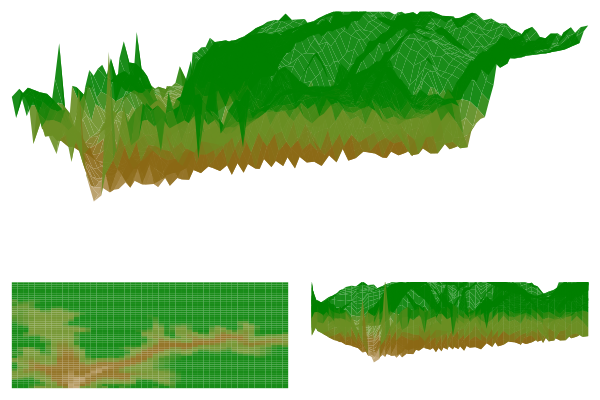

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [39]:
tr = rtrackk[1]

res         = 50
gifify      = false
show_track  = false
spatial_res = 200 # meter
dλ          = spatial_res/tr.norm

xx = LinRange(box.c1[1], box.c2[1], res)
yy = LinRange(box.c1[2], box.c2[2], res)


kwargs = Dict(:xlim=>(minimum((box.c1[1], box.c2[1])), maximum((box.c1[1], box.c2[1]))),
          :ylim=>(minimum((box.c1[2], box.c2[2])), maximum((box.c1[2], box.c2[2]))),
          :zlim=>(minimum((box.c1[2], box.c2[3])), maximum((box.c1[3], box.c2[3]))),
          :st=>:surface,
          :alpha=>0.9,
          :c=>cgrad(palette([:skyblue3, :skyblue2, :navajowhite3, :navajowhite3, :goldenrod4, :goldenrod4, :olivedrab, :olivedrab, :green, :green, :green, :green])),
          :colorbar=>false,
          :legend=>false,
         )

l   = @layout [a{0.7h} ; c{0.5w} d]
plt = surface(xx, yy, my_valley, layout=l, axis=([], false); kwargs...)
# This should be done with an imshow-like thing.... I think
surface!(plt[2], xx, yy, my_valley; camera=(0,90), kwargs...)
surface!(plt[3], xx, yy, my_valley; camera=(0,0), kwargs...)

if show_track
    λλ  = LinRange(0, 1, 50)
    pts = [tr.ipoint+λ*tr.direction for λ in λλ]
    segments = split_for_plot([pts[idx] for idx in 1:3]...)
    for segment in segments
        for idx in 1:3
            plot!(plt[idx], segment[1:3]..., color=segment[4], legend=false)
        end
    end
end

display(plt)
Plots.savefig(plt, "/Users/jlazar/research/TAMBO-MC/figures/fake_valley.pdf")

if gifify && ~show_track # These options don't play well together. Sorry
trayectory = Trayectory(tr, dλ)    
    @gif while trayectory.current_λ <=1
        step!(trayectory)
        segments = split_for_plot(trayectory)
        for segment in segments
            for idx in 1:3
                plot!(plt[idx], segment[1:3]..., color=segment[4], legend=false)
            end
        end
        plot!(plt[1], camera=(minimum((90, trayectory.current_λ*100)), minimum((90, trayectory.current_λ*100))))
    end every 1
end

In [8]:
for t in rtrackk[1:100]
    oned_valley = Tracks.reduce_f(t, my_valley)
    root_func(λ) = oned_valley(λ)-t(λ).z
    zeros = find_zeros(root_func, 0, 1)
    if length(zeros)>0
        plt = plot(0:0.01:1, oned_valley.(0:0.01:1))
        plot!(plt, 0:0.01:1, getfield.(t.(0:0.01:1), :z), zlim=(0,5000))
        scatter!(plt, zeros, getfield.(t.(zeros), :z))
        display(plt)
    end
end


LoadError: UndefVarError: rtrackk not defined

In [8]:
sc = scatter(xx[1:10000], yy[1:1000])
display(sc)
sc = scatter(xx[1:10000], zz[1:1000])
display(sc)
sc = scatter(yy[1:10000], zz[1:1000])
display(sc)

sc = scatter(θθ[1:10000], ϕϕ[1:1000])
display(sc)


LoadError: UndefVarError: xx not defined

In [9]:
air_density = 1.0
rock_density = 2.6

function total_column_depth(t::Track, valley::Function)
    oned_valley = Tracks.reduce_f(t, my_valley)
    root_func(λ) = oned_valley(λ)-t(λ).z
    zeros = find_zeros(root_func, 0, 1)
    rgen = vcat([0], zeros, [1])
    ranges = [(x[2]-x[1], is_in_mountain(t((x[1]+x[2])/2))) for x in zip(rgen[1:end-1], rgen[2:end])]
    cd = 0
    for x in ranges
        width, in_mountain = x
        density = in_mountain ? rock_density : air_density
        cd += width*t.norm*density
    end
    cd
end

total_column_depth (generic function with 1 method)

In [10]:
@time total_column_depth.(rtrackk[1:10000], Ref(my_valley))

LoadError: UndefVarError: rtrackk not defined